# Employee Salary Prediction

In [1]:
# Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split , StratifiedKFold , KFold , cross_val_score , GridSearchCV , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler , LabelEncoder , OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.linear_model import LinearRegression , Lasso , Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import r2_score , mean_absolute_error , root_mean_squared_error , mean_squared_error

In [3]:
# Load The Dataset

In [4]:
dataset = pd.read_csv('Salary_Data.csv')

In [5]:
dataset.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [6]:
dataset.shape

(6704, 6)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [8]:
dataset.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


In [9]:
dataset["Education Level"].unique()

array(["Bachelor's", "Master's", 'PhD', nan, "Bachelor's Degree",
       "Master's Degree", 'High School', 'phD'], dtype=object)

In [10]:
# Create a mapping dictionary
edu_mapping = {
    "Bachelor's Degree": "Bachelor's",
    "Bachelor's": "Bachelor's",
    "Master's Degree": "Master's",
    "Master's": "Master's",
    "PhD": "PhD",
    "phD": "PhD",
    "High School": "High School"
}

# Apply mapping
dataset['Education Level'] = dataset['Education Level'].replace(edu_mapping)

# Check updated counts
print(dataset['Education Level'].value_counts(),"\n")
print(dataset["Education Level"].unique())

Education Level
Bachelor's     3023
Master's       1861
PhD            1369
High School     448
Name: count, dtype: int64 

["Bachelor's" "Master's" 'PhD' nan 'High School']


In [11]:
dataset.isnull().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

In [12]:
# Filling Null Values

In [13]:
for col in dataset.select_dtypes(include=['object']).columns:
    dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

In [14]:
for colm in dataset.select_dtypes(include=['int64','float64']).columns:
    dataset[colm] = dataset[colm].fillna(dataset[colm].mean())

In [15]:
# Removing Duplicates row

In [16]:
dataset.duplicated().sum()

4913

In [17]:
dataset.drop_duplicates(inplace=True)

In [18]:
dataset.shape

(1791, 6)

In [19]:
# Outliers 

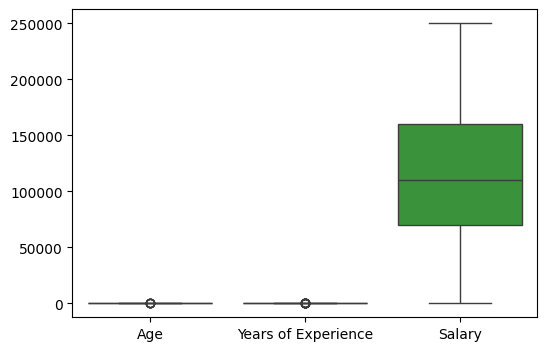

In [20]:
plt.figure(figsize=(6,4))
sns.boxplot(data=dataset[dataset.select_dtypes(include=['int64','float64']).columns])
plt.show()

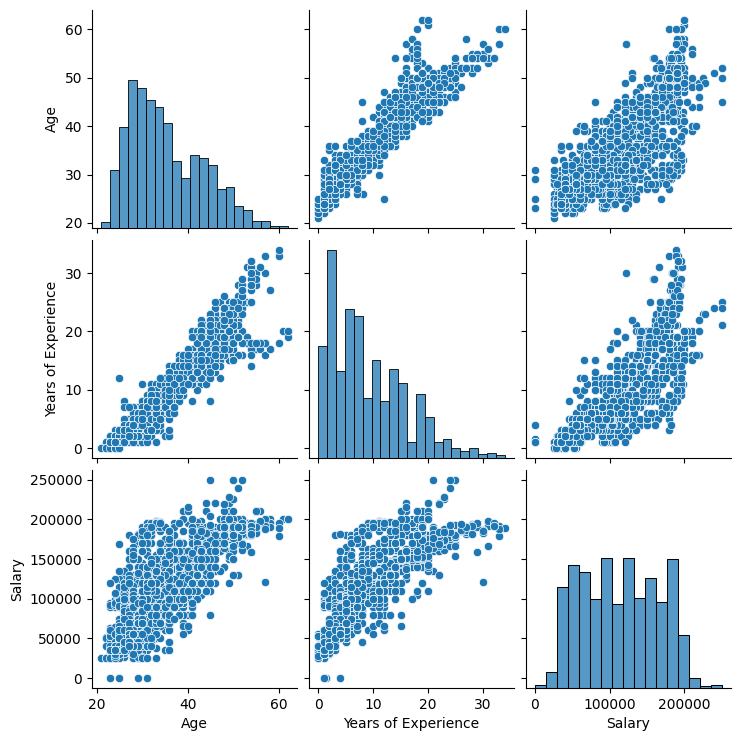

In [21]:
sns.pairplot(data=dataset)
plt.show()

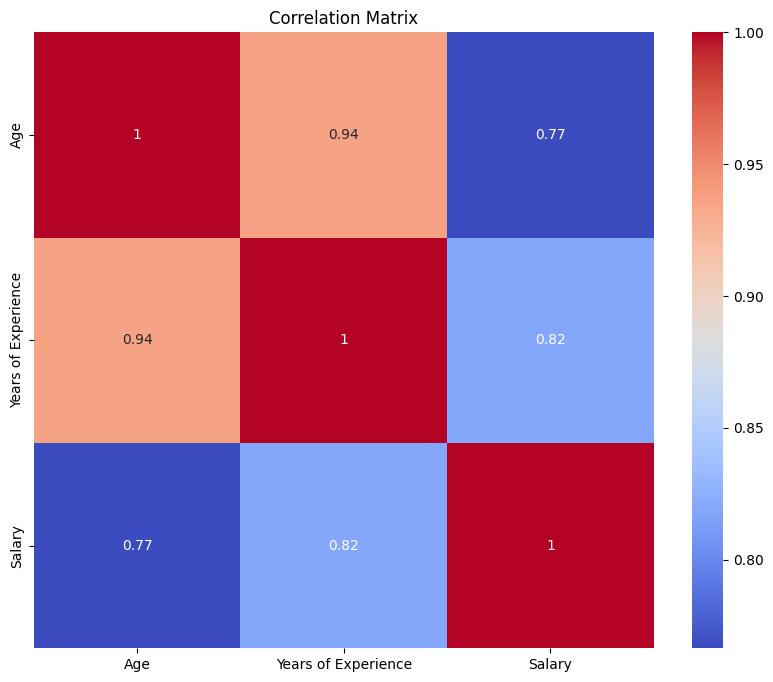

In [22]:
# Correlation matrix
corr = dataset[dataset.select_dtypes(include=['int64','float64']).columns].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


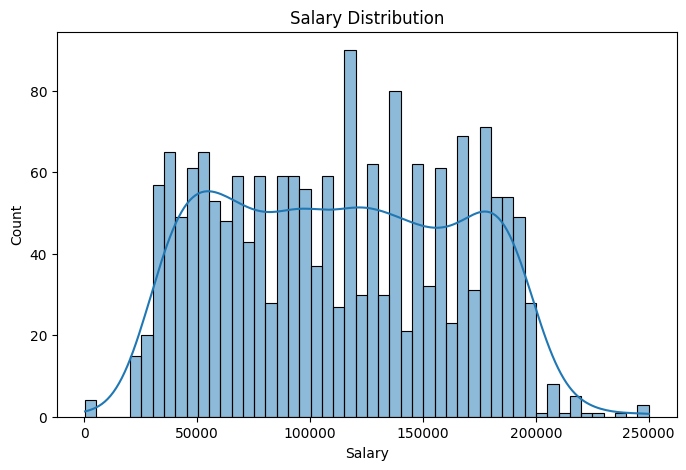

In [23]:
plt.figure(figsize=(8,5))
sns.histplot(dataset['Salary'], bins=50, kde=True)
plt.title("Salary Distribution")
plt.show()

In [24]:
dataset["Job Title"].value_counts()

Job Title
Software Engineer Manager    127
Full Stack Engineer          123
Senior Software Engineer      96
Senior Project Engineer       95
Back end Developer            81
                            ... 
Financial Advisor              1
Junior Designer                1
Chief Technology Officer       1
Technical Recruiter            1
Delivery Driver                1
Name: count, Length: 193, dtype: int64

In [25]:
# ------------------------------
threshold = 2  # replace categories appearing <= 2 times
counts = dataset['Job Title'].value_counts()
rare_categories = counts[counts <= threshold].index
dataset['Job Title'] = dataset['Job Title'].replace(rare_categories, 'Other')

In [26]:
dataset["Job Title"].value_counts()

Job Title
Other                           133
Software Engineer Manager       127
Full Stack Engineer             123
Senior Software Engineer         96
Senior Project Engineer          95
                               ... 
Senior Marketing Coordinator      3
Junior Data Analyst               3
Senior Product Designer           3
Junior Project Manager            3
Junior Marketing Analyst          3
Name: count, Length: 85, dtype: int64

In [27]:
dataset.shape

(1791, 6)

In [28]:
# Train-Test Split

In [29]:
x = dataset.iloc[:,:-1]
y = dataset['Salary']

In [30]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size=0.2 , random_state=42)

In [31]:
missing_titles = set(x_test['Job Title']) - set(x_train['Job Title'])
if missing_titles:
    move_back = x_test[x_test['Job Title'].isin(missing_titles)]
    x_train = pd.concat([x_train, move_back])
    y_train = pd.concat([y_train, y_test.loc[move_back.index]])
    x_test = x_test.drop(move_back.index)
    y_test = y_test.drop(move_back.index)

In [32]:
cat_columns = x_train.select_dtypes(include=['object']).columns
num_columns = x_train.select_dtypes(include=['int64','float64']).columns

In [33]:
# Encoding Chategorical Columns

In [34]:
preprocessor = ColumnTransformer([
    ("encode", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_columns),
    ("scale", StandardScaler(), num_columns)
])

In [35]:
models = {

    "Linear Regression":LinearRegression(),
    "SVM":SVR(),
    "KNN":KNeighborsRegressor(),
    "Decision Tree":DecisionTreeRegressor(),
    "Random Forest":RandomForestRegressor(),
    "Ridge":Ridge(),
    "Lasso":Lasso(),
    "XGBoost":xgb.XGBRegressor(),
    "AdaBoost":AdaBoostRegressor(),
    "GradientBoost":GradientBoostingRegressor()
}

In [36]:
for name , model in models.items():
    pipe = make_pipeline(preprocessor, model)
    pipe.fit(x_train , y_train)
    y_pred = pipe.predict(x_test)

    r2 = r2_score(y_test , y_pred)    
    mse = mean_squared_error(y_test , y_pred)    
    mae = mean_absolute_error(y_test , y_pred)    
    rmse = root_mean_squared_error(y_test , y_pred)

    print(f"{name}: R2 Score = {r2*100:.3f}")
    print(f"{name}: Mean Squared Error = {mse:.3f}")
    print(f"{name}: Mean Absolute Error = {mae:.3f}")
    print(f"{name}: Root Mean Squared Error = {rmse:.3f}")
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe , x_train , y_train , cv=cv , scoring='r2')
    print(f"{name}: Average CV R2 = {np.mean(scores)*100:.3f}\n")

Linear Regression: R2 Score = 70.149
Linear Regression: Mean Squared Error = 766018963.878
Linear Regression: Mean Absolute Error = 21025.212
Linear Regression: Root Mean Squared Error = 27677.048
Linear Regression: Average CV R2 = 69.560

SVM: R2 Score = -0.480
SVM: Mean Squared Error = 2578417227.697
SVM: Mean Absolute Error = 43664.765
SVM: Root Mean Squared Error = 50778.118
SVM: Average CV R2 = -1.110

KNN: R2 Score = 84.101
KNN: Mean Squared Error = 407986548.634
KNN: Mean Absolute Error = 13242.763
KNN: Root Mean Squared Error = 20198.677
KNN: Average CV R2 = 85.193

Decision Tree: R2 Score = 82.551
Decision Tree: Mean Squared Error = 447754792.578
Decision Tree: Mean Absolute Error = 12618.744
Decision Tree: Root Mean Squared Error = 21160.217
Decision Tree: Average CV R2 = 79.309

Random Forest: R2 Score = 89.251
Random Forest: Mean Squared Error = 275824575.742
Random Forest: Mean Absolute Error = 10661.179
Random Forest: Root Mean Squared Error = 16607.967
Random Forest: Ave

In [37]:
best_model = models["XGBoost"]
best_pipe = make_pipeline(preprocessor , best_model)
best_pipe.fit(x_train , y_train)
y_pred = best_pipe.predict(x_test)

In [38]:
print("Training Score : ",round(best_pipe.score(x_train , y_train)*100,3))
print("Testing Score : ",round(best_pipe.score(x_test , y_test)*100,3))
print("R2 Score :",round(r2_score(y_test , y_pred)*100,3))
print("Mean Squared Error :",round(mean_squared_error(y_test , y_pred),3))
print("Mean Absolute Error :",round(mean_absolute_error(y_test , y_pred),3))
print("Root Mean Squared Error :",round(root_mean_squared_error(y_test , y_pred),3))

Training Score :  98.564
Testing Score :  90.147
R2 Score : 90.147
Mean Squared Error : 252827755.097
Mean Absolute Error : 10266.715
Root Mean Squared Error : 15900.558


# HyperParameter Tuning

In [39]:
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300],
    'xgbregressor__max_depth': [3, 6, 9],
    'xgbregressor__learning_rate': [0.05, 0.1],
    'xgbregressor__subsample': [0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.8, 1.0],
    'xgbregressor__gamma': [0, 0.1]
}

In [40]:
grid = GridSearchCV(
    estimator=best_pipe,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error'
)

In [41]:
# grid.fit(x_train, y_train)

In [42]:
# print(f"Best Score : {-grid.best_score_}")

In [43]:
# Final Model

In [44]:
final_model = xgb.XGBRegressor()
final_pipe = make_pipeline(preprocessor , final_model)
final_pipe.fit(x_train , y_train)
y_pred = final_pipe.predict(x_test)

In [45]:
print("Training Score : ",round(final_pipe.score(x_train , y_train)*100,3))
print("Testing Score : ",round(final_pipe.score(x_test , y_test)*100,3))
print("R2 Score :",round(r2_score(y_test , y_pred)*100,3))
print("Mean Squared Error :",round(mean_squared_error(y_test , y_pred),3))
print("Mean Absolute Error :",round(mean_absolute_error(y_test , y_pred),3))
print("Root Mean Squared Error :",round(root_mean_squared_error(y_test , y_pred),3))

Training Score :  98.564
Testing Score :  90.147
R2 Score : 90.147
Mean Squared Error : 252827755.097
Mean Absolute Error : 10266.715
Root Mean Squared Error : 15900.558


In [46]:
# Visualizing Final Model

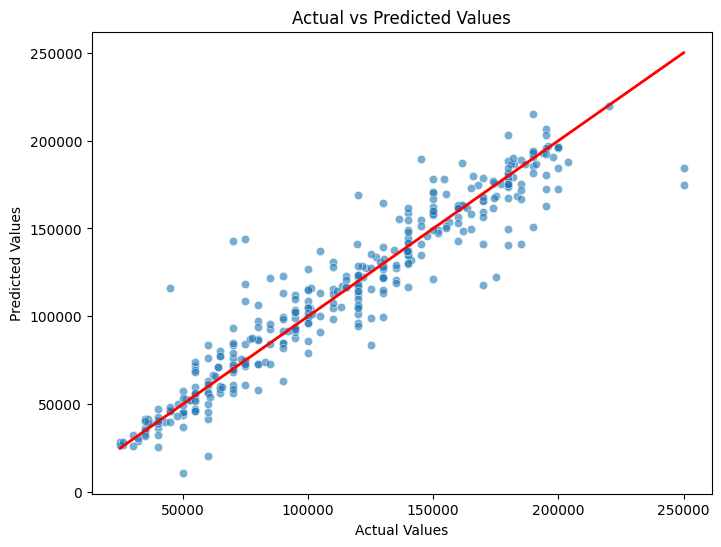

In [47]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
sns.lineplot(x=y_test, y=y_test, color='red', linewidth=2)  # perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [48]:
# Saving model

In [49]:
joblib.dump(final_pipe , "salary_prd_model.pkl")
print("Model Saved Successfully.")

Model Saved Successfully.
